<a href="https://colab.research.google.com/github/rp1177/CS461-MachineLearning-Principles/blob/main/Riddhi_Patel_sol4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import heapq
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random

from collections import deque
from itertools import accumulate, groupby

def set_seed(seed):  # For reproducibility, fix random seeds.
  random.seed(seed)
  np.random.seed(seed)

# Decision Tree

## Gini Impurity

To learn decision trees, we will use [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) to measure how "impure" a distribution (over labels) is.

In [ ]:
def gini_impurity(distribution):
  # distribution: [p_1 ... p_L] such that p_l >= 0 and sum_{l=1}^L p_l = 1

  #add up all the values in distribution and convert distribution into an array so we can traverse:

  distribution = np.array(distribution)
  n = distribution.sum()
  total_len = len(distribution)
  probability_sum = 0

  if(n == 1 and probability_sum >= 0):
    for i in range(total_len):

    # TODO: Implement
      probability_sum = probability_sum + (distribution[i] / n)**2

    gini = 1 - probability_sum

  return gini

## Split Loss

We compute the loss of a split $S = S_1 \perp S_2$ as
$$
\omega(S_1) \times \mathrm{Gini}(\widehat{D}^\omega_1) + \omega(S_2) \times \mathrm{Gini}(\widehat{D}^\omega_2)
$$
where

  - $\omega(x,y) \geq 0$ is used to weight each $(x, y) \in S$. We write $\omega(S') = \sum_{(x,y) \in S'} \omega(S')$.

  - $\widehat{D}^\omega_k$ is the empirical label distribution in split $S_k$ weighted by $\omega$. That is, the probability of label $l$ in $S_k$ under $\omega$ is estimated as $$\frac{1}{\omega(S_k)} \sum_{(x,y) \in S_k:\; y = l} \omega(x,y) $$ (we will define it as 0.5 if $\omega(S_k) = 0$).

For binary classification, we only need to know the (1) total weight of each split, and (2) the total weight of one label type (e.g., positive) in each split.


In [ ]:
def compute_split_loss(total1, total2, positive1, positive2):
  positive1_prob = positive1 / total1 if total1 > 0. else 0.5
  positive2_prob = positive2 / total2 if total2 > 0. else 0.5
  impurity1 = gini_impurity([1 - positive1_prob, positive1_prob])
  impurity2 = gini_impurity([1 - positive2_prob, positive2_prob])
  impurity = total1 * impurity1 + total2 * impurity2
  return impurity

## Stump Learning

We will implement the fast stump algorithm that scales linearly with data size (ignoring the sorting complexity).

In [ ]:
def fit_stump(data, weights=None, indices=None):  # O(dN)
  """
  Computes the best split on a dataset of N (input, label) pairs according to Gini impurity where the label is either +1 or -1.
  Each example is weighted by some nonnegative weight value (1.0 if None).
  Only the examples included in the list of indices are considered (all if None).
  """
  if weights is None:
    weights = np.ones(len(data))
  assert len(weights) == len(data)
  assert (weights >= 0).all()

  if indices is None:
    indices = list(range(len(data)))

  feature_best = None
  threshold_best = None
  loss_best = float('inf')

  for feature in range(len(data[0][0])):
    key = lambda i: data[i][0][feature]

    # Sorting indices so that feature values are nondecreasing.
    indices_sorted = sorted(indices, key=key)

    # Group indices with the same feature value for efficiency.
    groups = [list(group) for _, group in groupby(indices_sorted, key)]
    group_weights = [sum(weights[i] for i in group) for group in groups]
    group_weights_positive = [sum(weights[i] for i in group if data[i][1] == 1) for group in groups]

    # Precompute (1) total weight and (2) total positive label weight of every partition in O(N) time.
    cumulative_weights = list(accumulate(group_weights))
    cumulative_weights_positive = list(accumulate(group_weights_positive))
    total = cumulative_weights[-1]
    positive = cumulative_weights_positive[-1]

    # Loop over effective partitions.
    for group_num, (total1, positive1) in enumerate(zip(cumulative_weights[:-1], cumulative_weights_positive[:-1])):

      # TODO: Implement. You simply need to call compute_split_loss with right values.
      loss = None
      loss = compute_split_loss(total1, total-total1, positive1, positive-positive1)
      #to get total2 and positive2 we subtract from total1 and total which contains both total1 and total2. Same idea to get positive2.
      if loss < loss_best:
        loss_best = loss
        feature_best = feature
        current_feature_value = data[groups[group_num][0]][0][feature]
        next_feature_value = data[groups[group_num + 1][0]][0][feature]
        threshold_best = (current_feature_value + next_feature_value) / 2.

  # May return (None, None, float('inf')) if no split can be found (e.g., has one feature group for every dimension).
  return feature_best, threshold_best, loss_best

In [ ]:
import unittest

class TestFitStump(unittest.TestCase):

  def setUp(self):
    set_seed(42)
    num_features = 15
    self.dim = 13
    num_examples = 42
    num_examples_subset = 31

    # Random feature values in {0...num_features-1}
    self.data = [[np.random.randint(0, num_features, size=(self.dim,)), 2 * np.random.randint(2) - 1] for _ in range(num_examples)]
    self.weights = np.random.rand(num_examples)
    self.indices = np.random.choice(list(range(num_examples)), num_examples_subset, replace=False)

  def fit_stump_naive(self):  # O(dN^2)
    data = [self.data[i] for i in self.indices]
    weights = [self.weights[i] for i in self.indices]

    loss_best = float('inf')
    feature_best = None
    threshold_best = None
    for feature in range(self.dim):  # O(d)
      for threshold in self.get_thresholds():  # O(N)
        total1 = sum([weights[i] for i, (x, _) in enumerate(data) if x[feature] <= threshold])  # O(N)
        total2 = sum([weights[i] for i, (x, _) in enumerate(data) if x[feature] > threshold])
        positive1 = sum([weights[i] for i, (x, y) in enumerate(data) if x[feature] <= threshold and y == 1])
        positive2 = sum([weights[i] for i, (x, y) in enumerate(data) if x[feature] > threshold and y == 1])
        loss = compute_split_loss(total1, total2, positive1, positive2)
        if loss < loss_best:
          loss_best = loss
          feature_best = feature
          threshold_best = threshold

    return feature_best, threshold_best, loss_best

  def test_fit_stump(self):
    feature, threshold, loss = fit_stump(self.data, weights=self.weights, indices=self.indices)
    feature_gold, threshold_gold, loss_gold = self.fit_stump_naive()
    self.assertEqual(feature, feature_gold)
    self.assertAlmostEqual(threshold, threshold_gold)
    self.assertAlmostEqual(loss, loss_gold)
    print("test:",feature,feature_gold)

  def get_thresholds(self):
    feature_values = {}
    for x, _ in self.data:
      for value in x:
        feature_values[value] = True
    feature_values_sorted = sorted(feature_values.keys())
    thresholds = [(feature_values_sorted[j] + feature_values_sorted[j + 1]) / 2. for j in range(len(feature_values_sorted) - 1)]
    return thresholds

unittest.main(TestFitStump(), argv=[''], verbosity=2, exit=False)

test_fit_stump (__main__.TestFitStump) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.053s

OK


test: 3 3


## Tree Learning

Here's a simple (binary tree) node class.

In [ ]:
class Node:

  def __init__(self, parent):
    self.parent = parent
    self.child_left = None
    self.child_right = None
    self.feature = None  # Feature (i.e., dimension) to split on
    self.threshold = None
    self.label = None
    self.leaf = False

Top-down greedy heuristic to approximate a tree that minimizes Gini impurity of leaves. The number of leaves/regions of the tree is controlled by max depth and min split size.

In [ ]:
class BinaryClassifier:

  def predict(self, x):  # Given a vector x, return either +1 or -1
      raise NotImplementedError

  def predict_all(self, data_unlabeled):
    return [self.predict(x) for x in data_unlabeled]

  def evaluate_accuracy(self, data):
    num_correct = sum(y == self.predict(x) for (x, y) in data)
    return num_correct / len(data) * 100.

In [ ]:
class DecisionTree(BinaryClassifier):

  def __init__(self, data, weights=None, max_depth=10, min_split_size=1):
    if weights is None:
      weights = np.ones(len(data))
    self.root = self.fit(data, weights, max_depth, min_split_size)

  def fit(self, data, weights, max_depth, min_split_size):
    root = Node(None)
    queue = deque()
    queue.append((list(range(len(data))), root, 1))
    while queue:
      indices, node, depth = queue.popleft()
      weight_total = sum(weights[i] for i in indices)
      weight_total_positive = sum(weights[i] for i in indices if data[i][1] == 1)
      node.label = 1 if weight_total_positive > weight_total / 2. else -1

      if depth >= max_depth or len(indices) < min_split_size:
        node.leaf = True
        continue

      # TODO: Fit a stump on the data subset under the node (indicated by indices).
      feature, threshold, loss = fit_stump(data, weights, indices)

      # This should give you 3 variables: feature, threshold, and loss.

      #raise

      if loss == float('inf'):  # Could not find any split (e.g., pure).
        node.leaf = True
        continue

      node.feature = feature
      node.threshold = threshold
      indices_left = [i for i in indices if data[i][0][feature] <= threshold]
      indices_right = [i for i in indices if data[i][0][feature] > threshold]
      node.child_left = Node(None)
      node.child_right = Node(None)
      queue.append((indices_left, node.child_left, depth + 1))
      queue.append((indices_right, node.child_right, depth + 1))

    return root

  def predict(self, x):
    node = self.root
    while not node.leaf:
      node = node.child_left if x[node.feature] <= node.threshold else node.child_right
    return node.label

### Synthetic Data

To facilitate development, we will work with a (non-separable) synthetic dataset based on the XOR function.

In [ ]:
class DataXOR:

  def __init__(self, num_examples=1000, num_examples_train=500):
    assert 0 < num_examples_train < num_examples
    set_seed(42)
    data = []
    for _ in range(num_examples):
      mean, label = random.choice([((-2, -2), 1), ((2, -2), -1), ((2, 2), 1), ((-2, 2), -1)])
      data.append((np.random.randn(2) + mean, label))
    self.train = data[:num_examples_train]
    self.val = data[num_examples_train:]

  def plot_train(self):
    plt.scatter([x[0] for x, _ in self.train], [x[1] for x, _ in self.train], c=[y for _, y in self.train], cmap=matplotlib.cm.Paired)
    plt.plot()

  def draw_contour(self, model, M=200):
    # First, scatter plot training examples from which the tree is learned.
    self.plot_train()

    # Next, compute model predictions for (M, M) "grid" coordinates on the plane.
    # To do this, we need 2 * M^2 input values: M^2 values for dim 1 and M^2 values for dim 2.
    # We can get such evenly spaced values by NumPy's linspace and meshgrid.
    ticks = np.linspace(min(min(x) for x, _ in self.train), max(max(x) for x, _ in self.train), M)
    x1, x2 = np.meshgrid(ticks, ticks, indexing="ij")
    inputs = np.stack([x1, x2], axis=2).reshape(-1, 2)
    preds = np.array(model.predict_all(inputs)).reshape(x1.shape)  # {+1, -1}^{M x M}

    # Draw the contour based on the grid predictions. The bigger M is, the smoother the contour.
    plt.contourf(x1, x2, preds, cmap=matplotlib.cm.Paired, alpha=0.8)
    plt.plot()

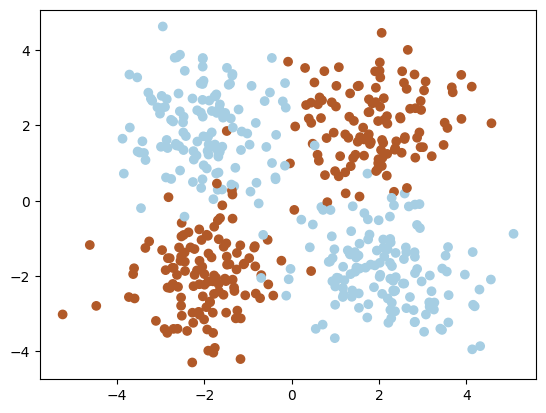

In [ ]:
data_xor = DataXOR()
data_xor.plot_train()

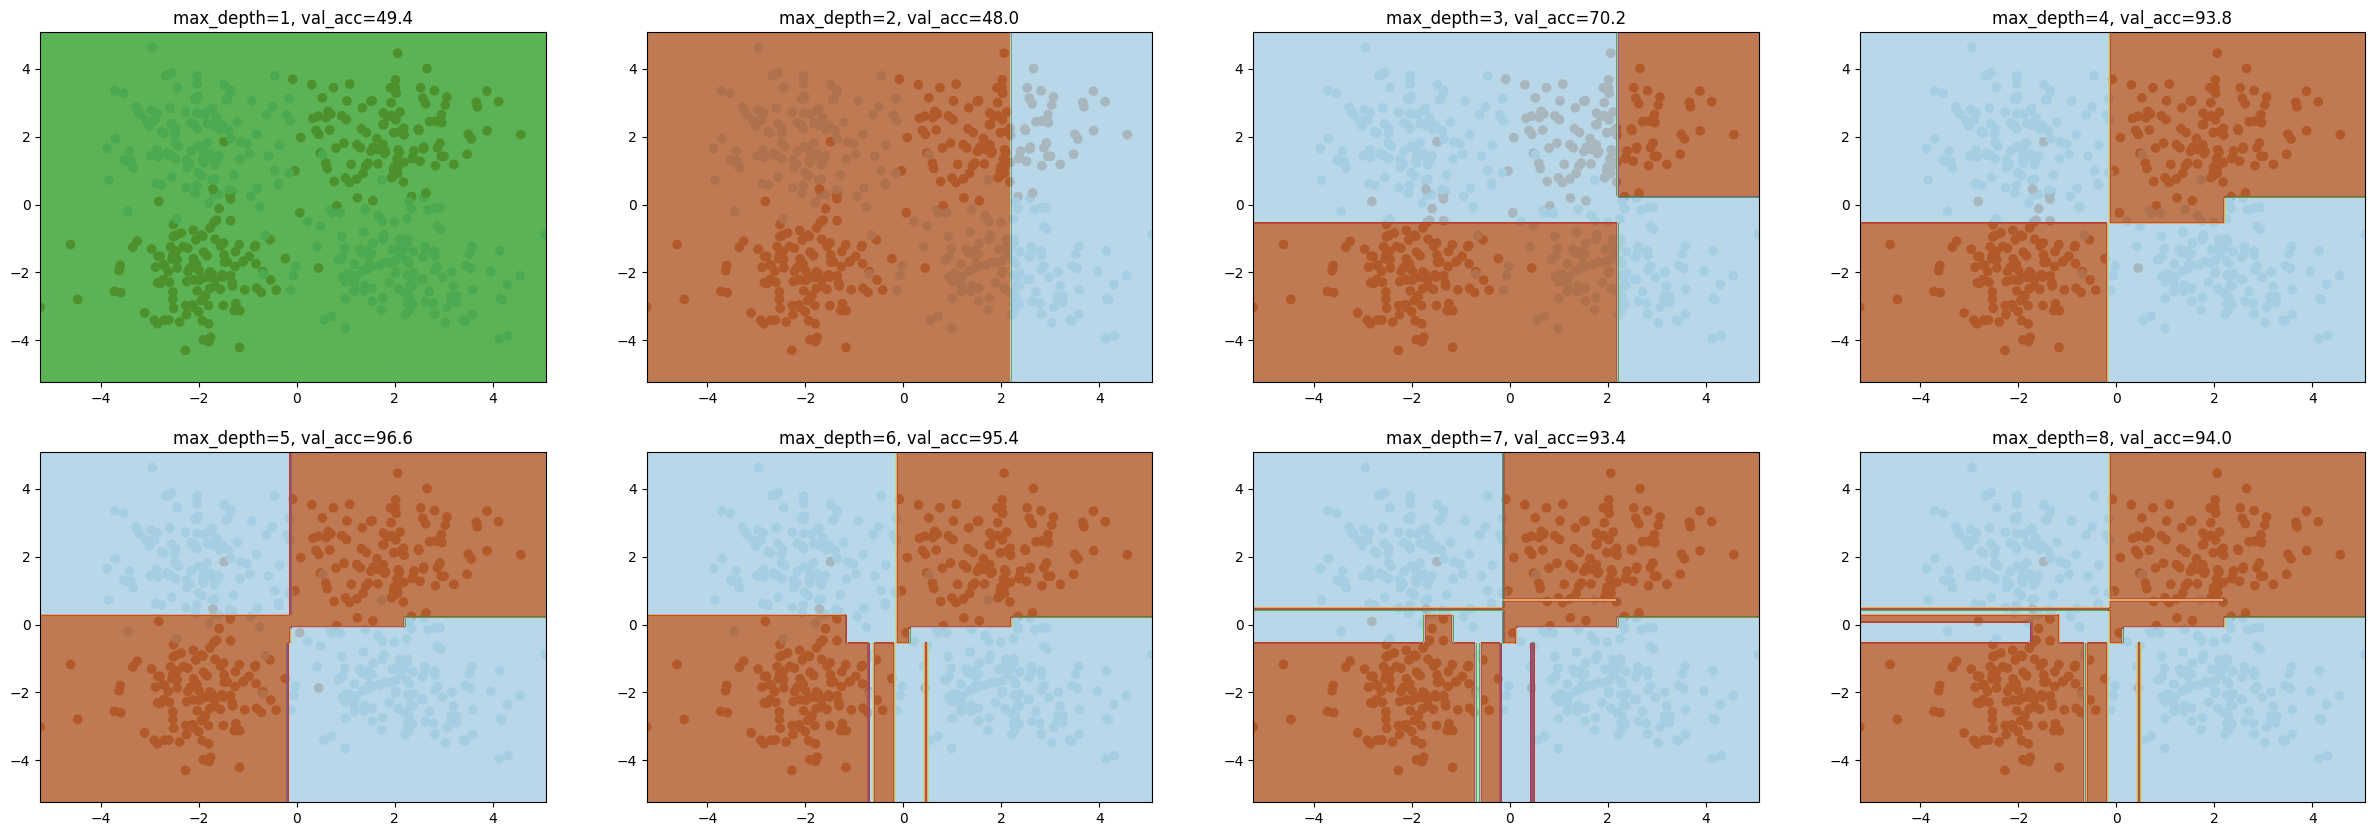

In [ ]:
trees = { max_depth: DecisionTree(data_xor.train, max_depth=max_depth) for max_depth in (1, 2, 3, 4, 5, 6, 7, 8) }
fig = plt.figure(figsize=(30, 10))
for i, (max_depth, tree) in enumerate(trees.items()):
  plt.subplot(2, 4, i + 1)
  plt.title('max_depth={:d}, val_acc={:.1f}'.format(max_depth, tree.evaluate_accuracy(data_xor.val)))
  data_xor.draw_contour(tree, M=200)
plt.show()

Not surprisingly, the deeper the tree is, the better it fits training data. But we can see that it starts to overfit and results in lower validation performance.

As discussed in class, a popular approach to combatting overfitting is to follow up with pruning based on [weakest-link cutting](https://online.stat.psu.edu/stat508/lesson/11/11.8/11.8.2). But this requires tree traversal that's a bit complicated, and we won't need pruning for ensembling, so we will omit this step for this assignment.

### Real Data

We will be applying these models to a spam classification dataset consisting of 3000 training examples with 57 continuous features. These features include the frequencies of certain words (e.g., credit, money, free), characters (e.g., $ and !) as well as a few features concerning the usage of capital letters. Download the data from [here](https://drive.google.com/drive/folders/1lfiXisIRPr17uve97a8_koqLx4ds6in_?usp=sharing). We will assume that we have the directory `data/spam/` in our Google Drive account containing the provided data.

In [ ]:
# Load the Drive helper and mount. You will have to authorize this operation.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle

datadir = '/content/drive/My Drive/data/spam/'

def load_data(split):
  with open(os.path.join(datadir, split + '.pkl'), 'rb') as f:
    return pickle.load(f)

data_train = load_data('train')
data_val = load_data('val')
data_test = load_data('x_test')

print('{:d}/{:d}/{:d} train/val/test examples, no labels provided for test'.format(len(data_train), len(data_val), len(data_test)))
print('Dimension {:d}'.format(len(data_train[0][0])))
print('{:d} positive, {:d} negative training examples'.format(sum(y == 1 for _, y in data_train), sum(y == -1 for _, y in data_train)))
print('x_1:', data_train[0][0])
print('y_1:', data_train[0][1])

3000/701/900 train/val/test examples, no labels provided for test
Dimension 57
1181 positive, 1819 negative training examples
x_1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.01, 0.0, 1.01, 5.05, 0.0, 1.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 55.0, 60.0]
y_1: -1


Let's automate hyperparameter tuning. We'll search values of max depth and min split size in log space, that is 1, 2, 4, 8, 16, ...

In [ ]:
def tune_tree(data_train, data_val, verbose=False):
  tree_best = None
  acc_val_best = 0.
  for max_depth in np.logspace(1, 5, num=3, base=2).astype(int):
    for min_split_size in np.logspace(0, 4, num=10, base=2).astype(int):
      tree = DecisionTree(data_train, max_depth=max_depth, min_split_size=min_split_size)
      acc_train = tree.evaluate_accuracy(data_train)
      acc_val = tree.evaluate_accuracy(data_val)
      print_string = 'max_depth={:d}   min_split_size={:d}   acc_train {:.2f}   acc_val {:.2f}'.format(max_depth, min_split_size, acc_train, acc_val)
      if acc_val > acc_val_best:
        acc_val_best = acc_val
        tree_best = tree
        print_string += ' <--------new best'
      if verbose:
        print(print_string)
  return tree_best, acc_val_best

In [ ]:
tree_best, acc_best = tune_tree(data_train, data_val, verbose=True)

max_depth=2   min_split_size=1   acc_train 79.67   acc_val 79.46 <--------new best
max_depth=2   min_split_size=1   acc_train 79.67   acc_val 79.46
max_depth=2   min_split_size=1   acc_train 79.67   acc_val 79.46
max_depth=2   min_split_size=2   acc_train 79.67   acc_val 79.46
max_depth=2   min_split_size=3   acc_train 79.67   acc_val 79.46
max_depth=2   min_split_size=4   acc_train 79.67   acc_val 79.46
max_depth=2   min_split_size=6   acc_train 79.67   acc_val 79.46
max_depth=2   min_split_size=8   acc_train 79.67   acc_val 79.46
max_depth=2   min_split_size=11   acc_train 79.67   acc_val 79.46
max_depth=2   min_split_size=16   acc_train 79.67   acc_val 79.46
max_depth=8   min_split_size=1   acc_train 94.90   acc_val 92.15 <--------new best
max_depth=8   min_split_size=1   acc_train 94.90   acc_val 92.15
max_depth=8   min_split_size=1   acc_train 94.90   acc_val 92.15
max_depth=8   min_split_size=2   acc_train 94.90   acc_val 92.15
max_depth=8   min_split_size=3   acc_train 94.83   a

Question: Report the result of your **best tree model** here.
- Training accuracy: 98.80
- Validation accuracy: 93.01




ORIGINAL/DEFAULT:
- Training accuracy: 98.80
- Validation accuracy: 93.01

ATTEMPT 1: min split base = 2, and max depth base = 3 (other values were default)
acc_train 98.63   acc_val 92.87 <--------new best

ATTEMPT 2: min split and max depth -- base = 3
max_depth=17   min_split_size=3   acc_train 98.73   acc_val 92.87 <--------new best

ATTEMPT3: min split -> default, max depth: num 3
max_depth=32   min_split_size=4   acc_train 99.30   acc_val 92.58 <--------new best

ATTEMPT4: min split-> default, max depth: num 4
max_depth=32   min_split_size=4   acc_train 99.30   acc_val 92.58 <--------new best

ATTEMPT5: minsplit -> default, max depth: num 8
max_depth=14   min_split_size=1   acc_train 98.03   acc_val 93.01 <--------new best

ATTEMPT 6: minsplit-> num = 8, maxdepth: num = 8
acc_train 98.03   acc_val 93.01

ATTEMPT 7: minsplit -> num = 2 , maxdepth: num = 8
max_depth=14   min_split_size=1   acc_train 98.03   acc_val 93.01 <--------new best

ATTEMPT8: misplit-> num = 10, max depth: num = 3


# Ensemble

## An Ensemble of Binary Classifiers

Let's write a generic ensemble model that keeps a list of binary classifiers each of which outputs either +1 or -1 given an input, along with their weights ("alphas"). The ensemble predicts the sign of weighted predictions.

In [ ]:
class Ensemble(BinaryClassifier):

  def __init__(self):
    self.classifiers = []  # Each must have a predict function outputting +1 or -1
    self.alphas = []

  def predict(self, x):
    score = sum(alpha * classifier.predict(x) for alpha, classifier in zip(self.alphas, self.classifiers))
    return np.sign(score)

## AdaBoost

AdaBoost (Freund and Schapire, 1997) is a seminal work on learning an ensemble. It works by iteratively training a classifier on a differently weighted version of the same training dataset. While any classifier can be used as a base classifier, the standard one is a (shallow) decision tree because it's easy to train and naturally admits weighted training (what we've already implemented above).

In [ ]:
def adaboost(data_train, data_val, max_steps=100, max_depth=7, min_split_size=24, patience=40, verbose=False):
  weights = np.full(len(data_train), 1. / len(data_train))

  # Will maintain ensemble scores on all data for efficiency
  scores_train_current = np.zeros(len(data_train))
  scores_val_current = np.zeros(len(data_val))

  ensemble = Ensemble()
  step_best = 0
  acc_val_best = 0
  for step in range(max_steps):
    tree = DecisionTree(data_train, weights=weights, max_depth=max_depth, min_split_size=min_split_size)
    preds = np.array([tree.predict(x) for x, _ in data_train])
    p = len(preds)


    # TODO: Implement AdaBoost

    #weighted_error calculation
    weight_error_accumulate = 0
    for i in range (p):
      if (preds[i] != data_train[i][1]):
         weight_error_accumulate = weight_error_accumulate + weights[i]

    weighted_error =  weight_error_accumulate

    #alpha calculation
    alpha = 0.5 * np.log((1 - weighted_error) / weighted_error)

    #weight update calculation
    total_weight = 0
    weights = (weights * np.exp(-alpha * np.array([y for _, y in data_train]) * preds))

    for i in range(len(data_train)):
      total_weight += weights[i]

    weights = weights / total_weight


    # Sanity check
    assert 0 <= weighted_error <= 0.5
    assert (weights >= 0).all()
    assert abs(1 - weights.sum()) < 1e-6

    # Update ensemble scores incrementally
    scores_train_current += alpha * preds
    scores_val_current += alpha * np.array([tree.predict(x) for x, _ in data_val])
    acc_train = sum(pred == y for pred, (_, y) in zip(np.sign(scores_train_current), data_train)) / len(data_train) * 100.
    acc_val = sum(pred == y for pred, (_, y) in zip(np.sign(scores_val_current), data_val)) / len(data_val) * 100.
    print_string = 'Step {:d}   weighted_error {:.4f}   acc_train {:.2f}   acc_val {:.2f}'.format(step, weighted_error, acc_train, acc_val)

    if acc_val > acc_val_best:
      step_best = step
      acc_val_best = acc_val
      print_string += ' <--------new best'
    elif step - step_best > patience:
      if verbose:
        print(print_string, '\nNo improvement in over {:d} steps, early stopping'.format(patience))
      break

    if verbose:
      print(print_string)

    ensemble.classifiers.append(tree)
    ensemble.alphas.append(alpha)

  # Only use the weak learners that gave us the best validation accuracy.
  ensemble.classifiers = ensemble.classifiers[: step_best + 1]
  ensemble.alphas = ensemble.alphas[: step_best + 1]
  return ensemble, acc_val_best

Let's try fitting an ensemble on the toy XOR dataset.

Best val acc: 96.60


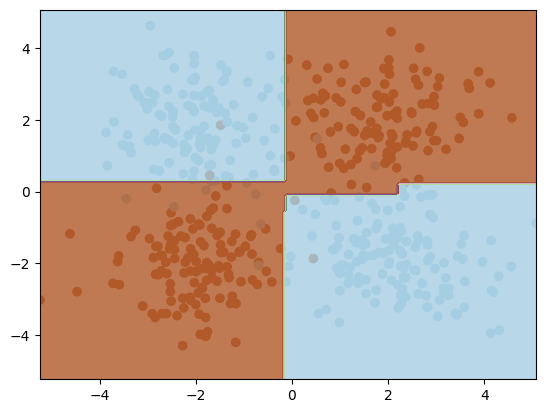

In [ ]:
ensemble_xor, acc_val_xor = adaboost(data_xor.train, data_xor.val)
print('Best val acc: {:.2f}'.format(acc_val_xor))
data_xor.draw_contour(ensemble_xor, M=200)

Now let's try learning an ensemble on the real dataset.

In [ ]:
ensemble_best, acc_val_best = adaboost(data_train, data_val, verbose=True)
print('Best val acc: {:.2f}'.format(acc_val_best))

Step 0   weighted_error 0.0640   acc_train 93.60   acc_val 91.73 <--------new best
Step 1   weighted_error 0.1619   acc_train 93.60   acc_val 91.73
Step 2   weighted_error 0.2070   acc_train 94.90   acc_val 92.87 <--------new best
Step 3   weighted_error 0.2242   acc_train 95.40   acc_val 93.87 <--------new best
Step 4   weighted_error 0.2518   acc_train 95.50   acc_val 93.15
Step 5   weighted_error 0.2038   acc_train 96.63   acc_val 93.87
Step 6   weighted_error 0.2222   acc_train 97.10   acc_val 94.29 <--------new best
Step 7   weighted_error 0.2884   acc_train 97.23   acc_val 94.44 <--------new best
Step 8   weighted_error 0.2087   acc_train 97.93   acc_val 94.01
Step 9   weighted_error 0.2727   acc_train 98.20   acc_val 94.58 <--------new best
Step 10   weighted_error 0.3156   acc_train 98.43   acc_val 93.58
Step 11   weighted_error 0.3672   acc_train 98.50   acc_val 94.44
Step 12   weighted_error 0.3688   acc_train 98.57   acc_val 94.01
Step 13   weighted_error 0.2915   acc_train 

table record:

>1.) adaboost(data_train, data_val, max_steps=100, **max_depth=4**, min_split_size=10, patience=20, verbose=False): **acc_train 97.93   acc_val 94.86** (default)

> 2.) adaboost(data_train, data_val, max_steps=100, **max_depth=5**, min_split_size=10, patience=20, verbose=False): **acc_train 97.33 acc_val 95.01**

> 3.) adaboost(data_train, data_val, max_steps=100, **max_depth=6**, min_split_size=10, patience=20, verbose=False) = **acc_train 99.33   acc_val 95.86**

>4.)adaboost(data_train, data_val, max_steps=100, max_depth=7, min_split_size=10, patience=20, verbose=False): **acc_train 99.13   acc_val 95.86**

>5.) adaboost(data_train, data_val, max_steps=100, **max_depth=8**, min_split_size=10, patience=20, verbose=False) = **acc_train 98.83   acc_val 95.44**

>6.) adaboost(data_train, data_val, max_steps=100, **max_depth=7, min_split_size=15**, patience=20, verbose=False) = **acc_train 99.80   acc_val 95.29**

>7.) adaboost(data_train, data_val, max_steps=100, **max_depth=7, min_split_size=20**, patience=20, verbose=False) = **acc_train 99.80   acc_val 95.72**

>8.) adaboost(data_train, data_val, max_steps=100,** max_depth=7, min_split_size=30**, patience=20, verbose=False) = **acc_train 99.93   acc_val 95.72**

>9.) adaboost(data_train, data_val, max_steps=100,** max_depth=7, min_split_size=30, patience=30**, verbose=False) = **acc_train 99.93   acc_val 95.72**

>10.)adaboost(data_train, data_val, **max_steps=100, max_depth=7, min_split_size=30**, patience=40, verbose=False) = **acc_train 99.93   acc_val 95.72**

>11.)adaboost(data_train, data_val, **max_steps=100, max_depth=7, min_split_size=24, patience=40**, verbose=False) = acc_train 99.93   acc_val 96.15 [BEST!]












Question: Report the result of your **best ensemble model** here.
- Training accuracy: 99.93
- Validation accuracy 96.15

This was achieved with: **max_steps=100, max_depth=7, min_split_size=24, patience=40**